In [25]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Initialization

In [26]:
#(a) Load the sound files. Each of the N = 2 sources is sampled at at 8192 Hz and contains p = 18000 samples.
s = np.array([np.loadtxt("sound1.dat"), np.loadtxt("sound2.dat")])
N = s.shape[0]

In [106]:
#(b) Create a random (& invertible) N ×N mixing matrix A and mix the sources: x(α) = As(α)
A = np.random.uniform(0.5, 1.0, (N, N))
x = np.dot(A, s)

In [107]:
#(c) Remove the temporal structure by permuting the columns of the N × p matrix X randomly.
xs = np.random.permutation(x.T).T

In [109]:
#(d) Calculate the correlations between the sources and the mixtures: ρ(si,xj) = cov(si,xj) / (σsi*σxj)
p = [((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1],i,j) for i in range(N) for j in range(N)]
print(p)

[(0.79566316823972227, 0, 0), (0.79326493606267057, 0, 1), (0.60683340486818704, 1, 0), (0.60996721036995716, 1, 1)]


In [110]:
#(e) Center the data to zero mean.
x_mean = xs.mean(axis=1).reshape(-1,1)
xsc = xs - x_mean

In [111]:
#(f) Initialize the unmixing matrix W with random values.
W = np.random.uniform(0, 1, (N, N))

# Optimization

In [112]:
def fhat(y):
    return 1 / (1 + np.exp(-y))
def fhatpp_fhatp(y):
    return 1 - 2*fhat(y)

In [113]:
#(a) Compute the update matrix ∆W using the “regular” gradient.
def dW(eta, W, x):
    xv = np.vstack( (x.T, x.T) )
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    return eta * (np.linalg.pinv(W).T + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))

In [114]:
#(b) Compute the update matrix ∆W using the natural gradient as described in the lecture notes.
def dWn(eta, W, x):
    return np.dot(dW(eta, W, x), np.dot(W.T, W))

In [126]:
#(c) Choose a suitable learning rate η and apply both versions to the data to unmix the sources.
eta = 0.2
Wa = W.copy()
Wb = W.copy()

for t in range(1,18000):
    xa = xsc[:,t]
    regular = dW(eta/float(t), Wa, xa)
    natural = dWn(eta/float(t), Wb, xa)
    if (regular.sum()<0.00000001) and (regular.sum()<0.00000001):
        break
    Wa += regular
    Wb += natural

shata = np.dot(Wa, x) + x_mean
shatb = np.dot(Wb, x) + x_mean

# Results

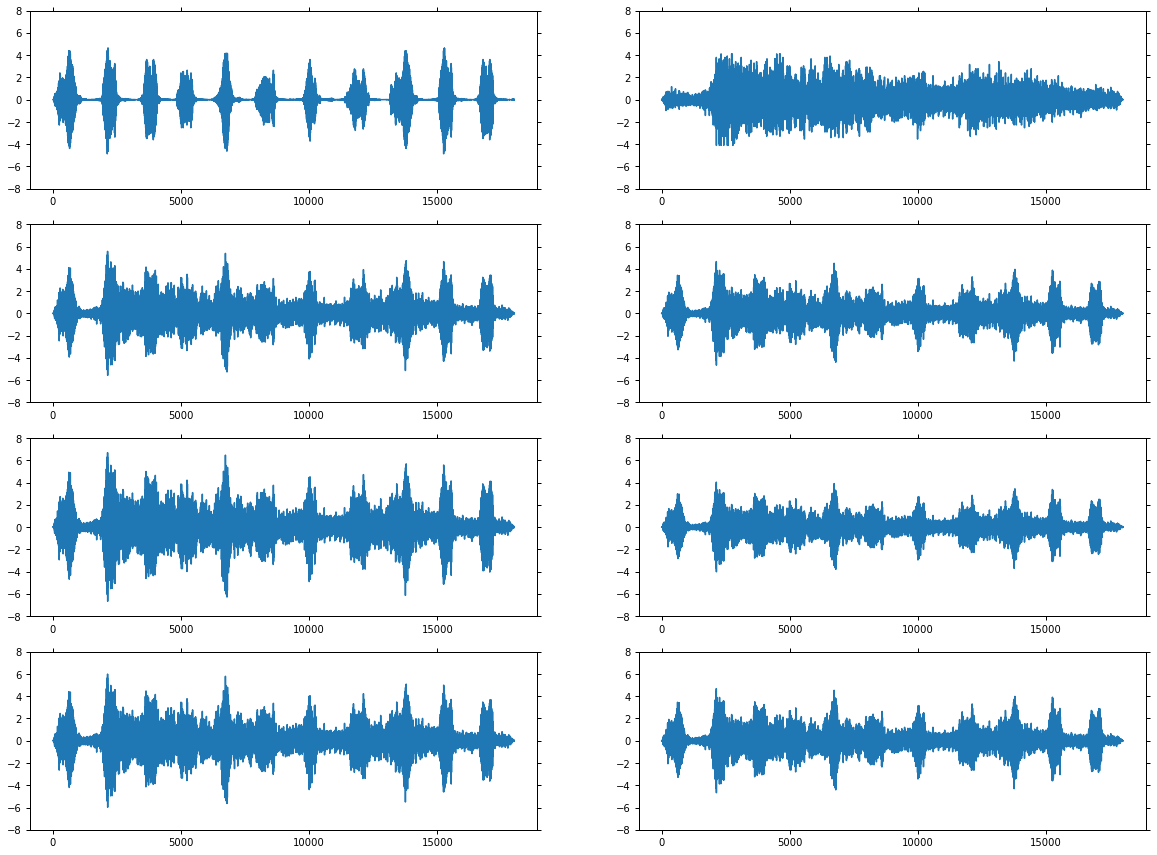

In [127]:
#(a) Plot & Play 
#(i) the original sounds (e.g. use scipy.io.wavfile to save playable files), 
#(ii) the mixed sources (before and after the data permutation), 
#and the recovered signals (estimated sources) ˆs = Wx using the unpermuted data.

#(i)
fig = plt.figure(figsize=(20,30))
limits = [-8,8]

ax1 = plt.subplot(821)
ax1.plot(range(s.shape[1]), s[0])
ax1.set_ylim(limits)

ax2 = plt.subplot(822)
ax2.plot(range(s.shape[1]), s[1])
ax2.set_ylim(limits)


ax1 = plt.subplot(823)
ax1.plot(range(x.shape[1]), x[0])
ax1.set_ylim(limits)

ax2 = plt.subplot(824)
ax2.plot(range(x.shape[1]), x[1])
ax2.set_ylim(limits)
#(iii)

ax3 = plt.subplot(825)
ax3.plot(range(shata.shape[1]), shata[0])
ax3.set_ylim(limits)

ax4 = plt.subplot(826)
ax4.plot(range(shata.shape[1]), shata[1])
ax4.set_ylim(limits)


ax5 = plt.subplot(827)
ax5.plot(range(shatb.shape[1]), shatb[0])
ax5.set_ylim(limits)

ax6 = plt.subplot(828)
ax6.plot(range(shatb.shape[1]), shatb[1])
ax6.set_ylim(limits)


plt.show()

In [128]:
#(b) Calculate the correlations (as above) between the true sources and the estimations.
regular = [((np.cov(s[i], shata[j]) / (np.std(s[i]) * np.std(shata[j])))[0,1],i,j) for i in range(N) for j in range(N)]
natural = [((np.cov(s[i], shatb[j]) / (np.std(s[i]) * np.std(shatb[j])))[0,1],i,j) for i in range(N) for j in range(N)]

print("\nRegular")
print(regular)
print("\nNatural+mean")
print(natural)


Regular
[(0.79396017304399091, 0, 0), (0.79674266016945028, 0, 1), (0.60906137308077635, 1, 0), (0.60541439804262209, 1, 1)]

Natural+mean
[(0.79456175340807178, 0, 0), (0.79538155473378869, 0, 1), (0.60827582790091472, 1, 0), (0.6072027261534384, 1, 1)]


In [174]:
#(c) For every 1000th update, plot ||∆W||2F :=  Ni=1,j=1(∆wi,j)2 to compare the convergence speed for the two gradient methods. Whiten your data before applying ICA and compare the learning speeds again. Describe the differences between the two variants of the learning algorithm.


In [175]:
#(d) Plot the density of the mixed, unmixed, and true signals & interpret your results.